In [1]:
import mne
import json
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# --- Set paths ---
edf_path = Path("data/raw/P002_1_raw.edf")
json_path = Path("data/labels/sleep_block_spindle_output_P002_1.json")


In [5]:
raw = mne.io.read_raw_edf("data/edf/P002_1_raw.edf", preload=True)

# List all channel names
print(raw.ch_names)

# Or more detailed channel info
print(raw.info)

# Just EEG channel names (excluding EOG, ECG, etc.)
eeg_channels = mne.pick_types(raw.info, eeg=True)
print([raw.ch_names[p] for p in eeg_channels])


Extracting EDF parameters from /home/subahini/Desktop/Master Project/spindle-project/code/data/edf/P002_1_raw.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5967199  =      0.000 ... 29835.995 secs...
['Kinn', 'Bein li', 'EKG', 'Bein re', 'REF', 'E1', 'E2', 'A1', 'C3', 'C4', 'A2', 'O1', 'O2', 'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T3', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', 'Oz', 'Licht_BU', 'Nasal Pressure', 'Thorax', 'Abdomen', 'Gravity X', 'Gravity Y', 'Plethysmogram', 'Pulse', 'RD-Quality', 'SpO2', 'SpO2 BB', 'Herzfrequenz_DR', 'SpO2-Qualität_DR', 'Flow_DR', 'Schnarchen_DR', 'Aktivität_DR', 'Erhebung_DR', 'Lage_DR', 'Phase_DR', 'RMI_DR', 'RR_DR', 'XSum_DR', 'Atemzugsvolumen_', 'XFlow_DR']
<Info | 8 non-empty values
 bads: []
 ch_names: Kinn, Bein li, EKG, Bein re, REF, E1, E2, A1, C3, C4, A2, O1, ...
 chs: 52 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 100.0 Hz
 meas_date: 2001-01-01 21:32:27 UTC
 nchan: 52


In [2]:
# --- Load EEG ---
raw = mne.io.read_raw_edf(edf_path, preload=True)
sfreq = raw.info['sfreq']
total_duration_sec = raw.n_times / sfreq
print(f"EEG Duration: {total_duration_sec / 3600:.2f} hours")



Extracting EDF parameters from /home/subahini/Desktop/Master Project/spindle-project/notebooks/data/raw/P002_1_raw.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5967199  =      0.000 ... 29835.995 secs...
EEG Duration: 8.29 hours


In [7]:
# --- Load spindle JSON ---
with open(json_path, 'r') as f:
    spindle_data = json.load(f)


    # json is in dictory form
print("Top-level JSON keys:", spindle_data.keys())
first_key = list(spindle_data.keys())[0]
print("First key:", first_key)
print("Value under that key:", spindle_data[first_key][:2])  # print first 2 entries
print("Type of value:", type(spindle_data[first_key][0]))

# Extract spindles from correct key
spindle_list = spindle_data["detected_spindles"]

# Standardize format
spindles = [
    {"channel": s["channel_names"][0], "start": float(s["start"]), "end": float(s["end"])}
    for s in spindle_list
]


Top-level JSON keys: dict_keys(['detected_spindles', 'nrem_duration', 'wake_duration', 'sleep_duration', 'rem_duration', 'spindle_rate', 'NREM_stages_from_reader_annotations', 'sleep_stages_parsed_list'])
First key: detected_spindles
Value under that key: [{'start': 1669.572, 'end': 1670.604, 'channels': [1], 'channel_names': ['c4-ref']}, {'start': 1676.488, 'end': 1677.004, 'channels': [1], 'channel_names': ['c4-ref']}]
Type of value: <class 'dict'>


In [8]:
# --- Segment EEG ---
window_len = 2.0  # seconds
step_size = 1.0   # seconds
train_limit_sec = 3 * 3600  # first 3 hours

starts = np.arange(0, train_limit_sec - window_len, step_size)

segments = []
labels = []

for start in starts:
    end = start + window_len
    label = 0
    for sp in spindles:
        if sp["start"] < end and sp["end"] > start:
            label = 1
            break
    segments.append((start, end))
    labels.append(label)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


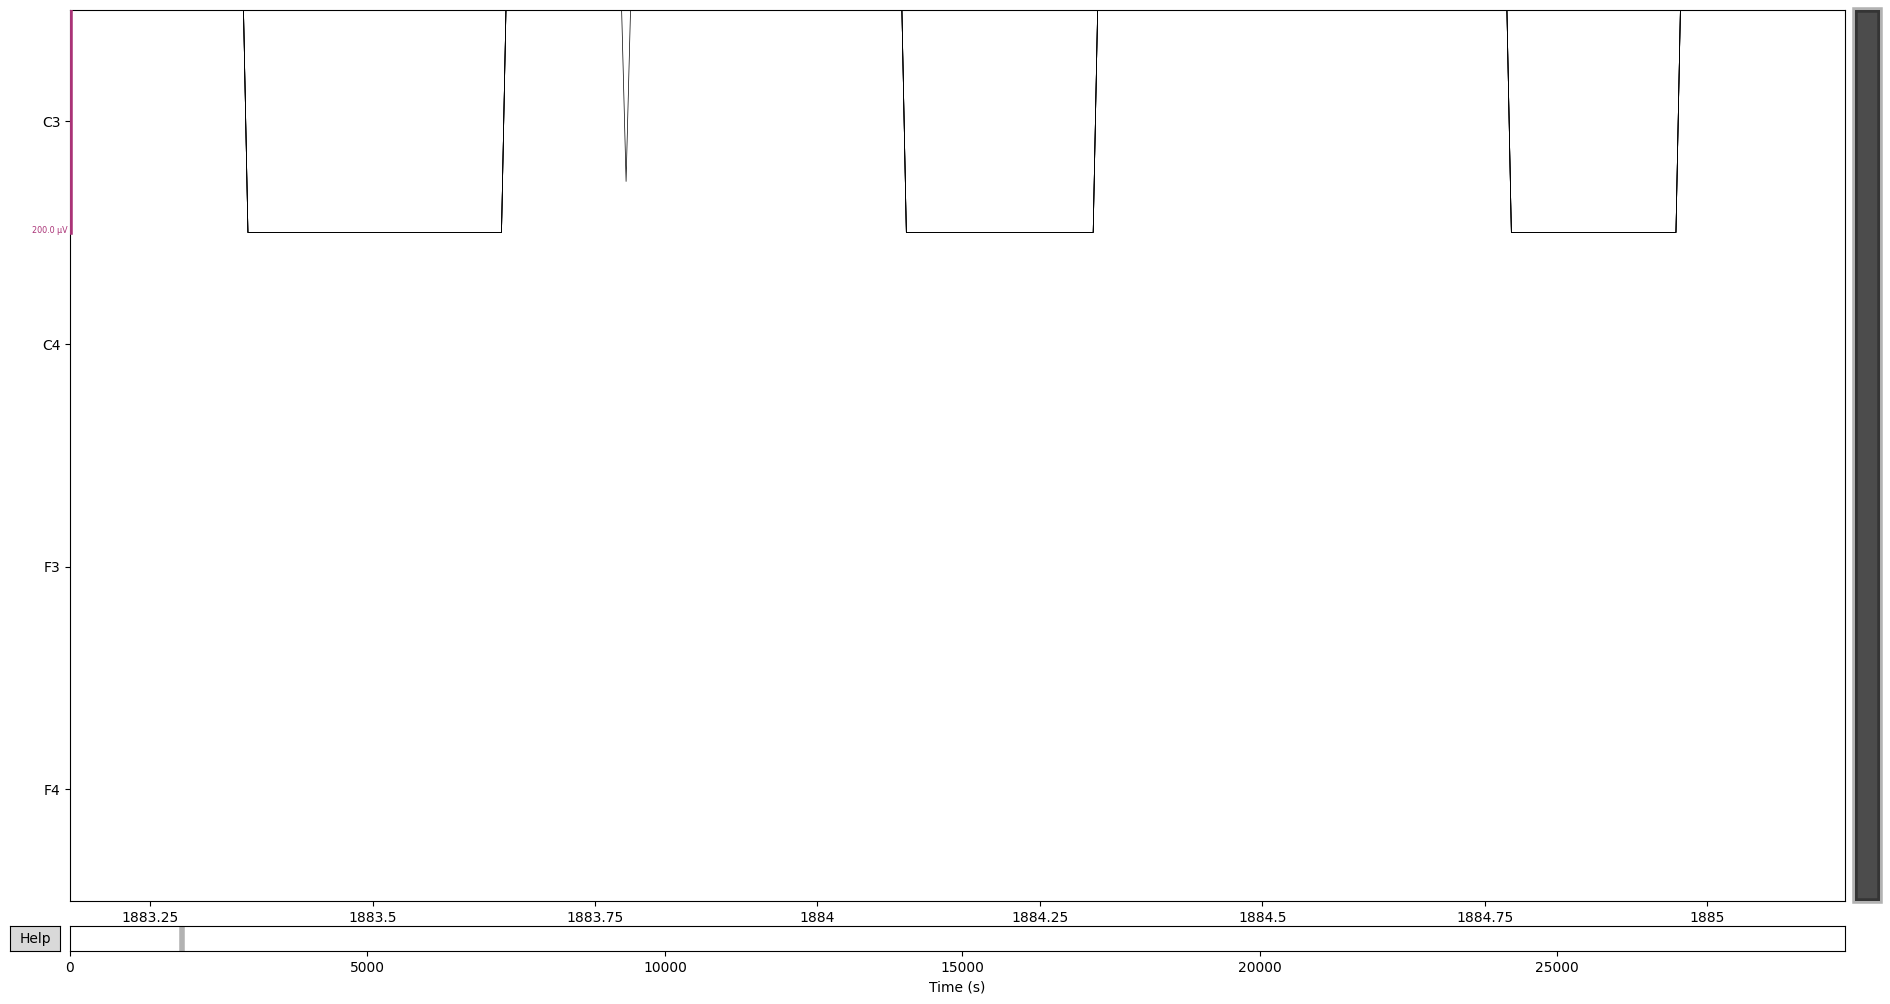

In [3]:
import mne
# %% CAR across ALL EEG channels, then plot C3/C4/F3/F4 (no filtering)
import mne
import numpy as np

# --- Config ---
edf_path = "data/edf/P002_1_raw.edf"
start_sec = 1883.160      # where to begin the view
duration_sec = 2.0    # window length to display (seconds)
scale_uv = 100        # display scale in microvolts (try 50–200)

# Render inside the notebook
mne.viz.set_browser_backend("matplotlib")

# Load EDF
raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

# Apply CAR across ALL EEG channels

raw_car = raw.copy()
raw_car.set_eeg_reference('average')
# Pick the four channels to display (order preserved if present)
show_chs = [c for c in ["C3", "C4", "F3", "F4"] if c in raw_car.ch_names]
if not show_chs:
    raise RuntimeError("None of C3/C4/F3/F4 found in this EDF.")

raw_show = raw_car.copy().pick_channels(show_chs)

# Plot (no filtering)
raw_show.plot(
    start=start_sec,
    duration=duration_sec,
    n_channels=len(show_chs),
    scalings=dict(eeg=scale_uv * 1e-6),  # convert µV -> V
    remove_dc=True,
    clipping="clamp",
    show_scrollbars=True,

    title=f"C3/C4/F3/F4 | CAR across ALL EEG | No filtering | {start_sec:.2f}–{start_sec+duration_sec:.2f}s"
);
